In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#import dataframe: 
df = pd.read_csv("../data/raw/biopac_raw.csv",dtype={"label": "str"})

In [3]:
df

,timestamp_ms,ECG,PPG,SKT,EDA,label
0,1733336643000,0.000458,0.220642,33.2769,1.661680,NaN
1,1733336643001,0.000153,0.216064,33.2775,1.664730,NaN
2,1733336643002,0.000305,0.215759,33.2775,1.660150,NaN
3,1733336643003,0.000000,0.213013,33.2787,1.660150,NaN
4,1733336643004,0.000153,0.209961,33.2775,1.660150,NaN
...,...,...,...,...,...,...
3668951,1733340311951,0.042725,0.238647,34.9596,0.965880,NaN
3668952,1733340311952,0.040588,0.235596,34.9614,0.964354,NaN
3668953,1733340311953,0.039978,0.235291,34.9614,0.964354,NaN
3668954,1733340311954,0.040436,0.234985,34.9602,0.967406,NaN


In [4]:
df_subset = df[['timestamp_ms', 'ECG', 'PPG']].copy()
# Convert to relative time (in seconds)
df_subset['time'] = (df_subset['timestamp_ms'] - df_subset['timestamp_ms'].iloc[0]) / 1000.0


In [5]:
df_subset

,timestamp_ms,ECG,PPG,time
0,1733336643000,0.000458,0.220642,0.000
1,1733336643001,0.000153,0.216064,0.001
2,1733336643002,0.000305,0.215759,0.002
3,1733336643003,0.000000,0.213013,0.003
4,1733336643004,0.000153,0.209961,0.004
...,...,...,...,...
3668951,1733340311951,0.042725,0.238647,3668.951
3668952,1733340311952,0.040588,0.235596,3668.952
3668953,1733340311953,0.039978,0.235291,3668.953
3668954,1733340311954,0.040436,0.234985,3668.954


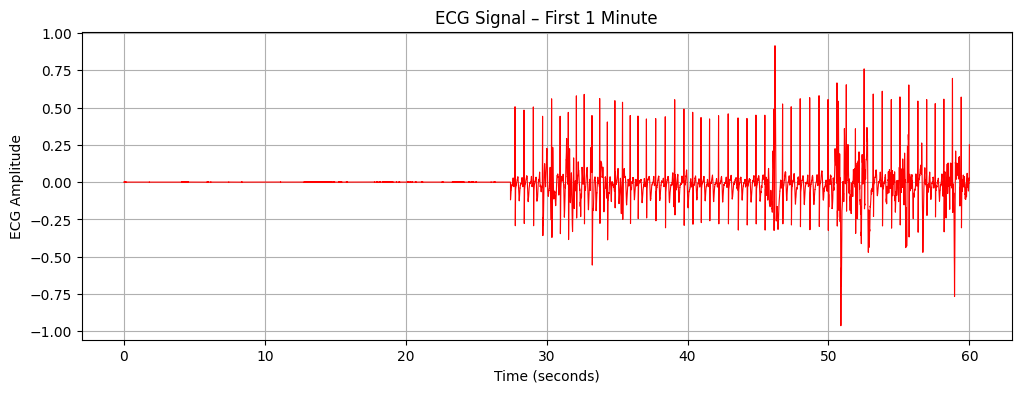

In [8]:
# Visualizing the one  minute ECG waveform
one_minute_df = df_subset[df_subset['time'] <= 60]
plt.figure(figsize=(12, 4))
plt.plot(one_minute_df['time'], one_minute_df['ECG'], color='red', linewidth=0.8)
plt.title("ECG Signal – First 1 Minute")
plt.xlabel("Time (seconds)")
plt.ylabel("ECG Amplitude")
plt.grid(True)
plt.show()


In [10]:
import plotly.express as px

fig = px.line(
    one_minute_df,
    x='time',
    y='ECG',
    title='ECG Signal (First 1 Minute)',
    
)
fig.show()


In [12]:
from scipy.stats import skew, kurtosis

In [14]:
signal = df_subset['ECG'].values
fs = 1000                # sampling rate (Hz)
win_sec = 2
win_len = int(fs * win_sec)
step = win_len
features = []

In [17]:
for start in range(0, len(signal) - win_len, win_len):   # non-overlapping signal
    seg = signal[start:start + win_len]
    mean_ = np.mean(seg)
    var_ = np.var(seg)
    med_ = np.median(seg)
    skew_ = skew(seg)
    kurt_ = kurtosis(seg)
    zcr_ = np.sum(np.diff(np.sign(seg)) != 0) / win_len
    t_mid = df_subset['time'].iloc[start + win_len//2]
    features.append([t_mid, mean_, var_, med_, skew_, kurt_, zcr_])

df_features = pd.DataFrame(features, columns=[
    'time_mid', 'mean', 'variance', 'median', 'skewness', 'kurtosis', 'zcr'
])
df_features.head()


,time_mid,mean,variance,median,skewness,kurtosis,zcr
0,1.0,0.000219,3.679919e-08,0.000305,-0.235666,0.167280,0.3830
1,3.0,0.000228,3.112852e-08,0.000305,-0.107417,0.063204,0.3200
2,5.0,0.000333,5.633476e-08,0.000305,0.608478,0.849265,0.1920
3,7.0,0.000307,3.764642e-08,0.000305,0.216190,-0.022511,0.2020
4,9.0,0.000242,3.255980e-08,0.000305,-0.022918,0.097817,0.2945


In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = StandardScaler().fit_transform(df_features.iloc[:, 1:])
kmeans = KMeans(n_clusters=4, random_state=42)
df_features['cluster'] = kmeans.fit_predict(X)


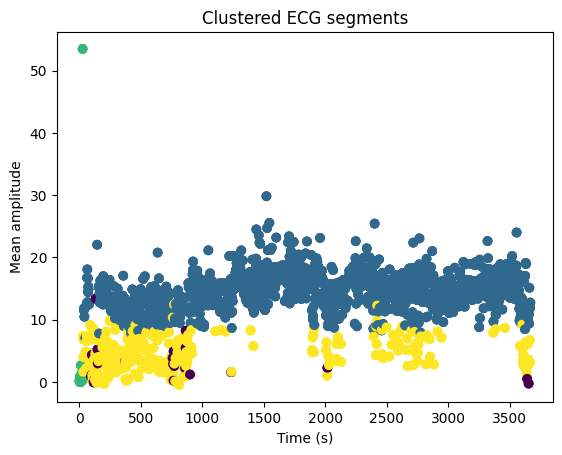

In [25]:
import matplotlib.pyplot as plt
plt.scatter(df_features['time_mid'], df_features['kurtosis'], c=df_features['cluster'])
plt.xlabel("Time (s)")
plt.ylabel("Mean amplitude")
plt.title("Clustered ECG segments")
plt.show()


In [26]:
df_features

,time_mid,mean,variance,median,skewness,kurtosis,zcr,cluster
0,1.0,0.000219,3.679919e-08,0.000305,-0.235666,0.167280,0.3830,2
1,3.0,0.000228,3.112852e-08,0.000305,-0.107417,0.063204,0.3200,2
2,5.0,0.000333,5.633476e-08,0.000305,0.608478,0.849265,0.1920,2
3,7.0,0.000307,3.764642e-08,0.000305,0.216190,-0.022511,0.2020,2
4,9.0,0.000242,3.255980e-08,0.000305,-0.022918,0.097817,0.2945,2
...,...,...,...,...,...,...,...,...
5497,3659.0,-0.015433,6.963208e-03,-0.010834,2.386446,15.142762,0.0170,1
5498,3661.0,-0.012757,1.196562e-02,-0.015793,1.409833,6.768246,0.0115,3
5499,3663.0,-0.020724,1.508568e-02,-0.022659,0.827808,3.097193,0.0305,3
5500,3665.0,-0.007206,1.117182e-02,-0.011597,2.369863,11.913678,0.0145,1
